In [217]:
#import Packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import robust_scale
import contextily

import libpysal as ps
from pysal.lib import weights
from pysal.model import mgwr, spreg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

## Read Demographic Data

In [298]:
md_bgs = gpd.read_file('data/nhgis0002_shape/nhgis0002_shapefile_tl2021_240_blck_grp_2021.zip')
md_bgs.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G24000100001001,24,001,000100,1,240010001001,Block Group 1,G5030,S,114609102.0,2207428.0,+39.6704707,-078.3878895,79360.017881,1.168165e+08,"POLYGON ((1491362.808 388017.416, 1491372.773 ..."
1,G24000100001002,24,001,000100,2,240010001002,Block Group 2,G5030,S,215159992.0,508136.0,+39.6796402,-078.5461225,71818.111670,2.156681e+08,"POLYGON ((1480962.440 372591.580, 1480911.970 ..."
2,G24000100001003,24,001,000100,3,240010001003,Block Group 3,G5030,S,156974534.0,5055373.0,+39.5688450,-078.5444290,74433.243094,1.620299e+08,"POLYGON ((1486026.812 366003.988, 1486020.868 ..."
3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872398.0,755914.0,+39.5962583,-078.6718297,40847.450865,6.062833e+07,"POLYGON ((1465943.510 374251.579, 1465955.177 ..."
4,G24000100002002,24,001,000200,2,240010002002,Block Group 2,G5030,S,46631900.0,903548.0,+39.6858145,-078.6757386,38663.844338,4.753545e+07,"POLYGON ((1465943.510 374251.579, 1465915.359 ..."


In [299]:
md_acs_data = pd.read_csv('data/nhgis0002_csv/nhgis0002_ds254_20215_blck_grp.csv',encoding='latin-1')
#subset for Baltimore region
balt_acs_data = md_acs_data[md_acs_data["COUNTY"].str.startswith("Balt")]
#Subset for Baltimore city
#balt_acs_data = md_acs_data[md_acs_data["COUNTY"].str.startswith("Baltimore c")]

Based on the provided codebook, I can extract the columns I need:

In [300]:
#Divide by category to keep track
population = ['AON4E001']
race = ['AON5E001','AON5E002','AON5E003']
education = ['AOP8E001', 'AOP8E022', 'AOP8E023', 'AOP8E024', 'AOP8E025']
poverty = ['AOQEE001', 'AOQEE002']
mhi = ['AOQIE001']
rent = ['AOSPE001', 'AOSPE003']
occupancy =['AOSOM001', 'AOSOM003']


cols_need = ['GISJOIN'] + population + race + education + poverty + mhi + rent + occupancy
balt_acs_data_new = balt_acs_data[cols_need]
balt_acs_data_new.head()

,GISJOIN,AON4E001,AON5E001,AON5E002,AON5E003,AOP8E001,AOP8E022,AOP8E023,AOP8E024,AOP8E025,AOQEE001,AOQEE002,AOQIE001,AOSPE001,AOSPE003,AOSOM001,AOSOM003
393,G24000504001001,1409,1409,665,363,843,158,82,0,0,482,13,94262.0,482,83,91,18
394,G24000504001002,992,992,552,269,563,114,18,0,6,309,57,47719.0,309,126,86,13
395,G24000504001003,2038,2038,1893,124,2038,417,229,45,31,1517,88,43839.0,1517,1109,270,78
396,G24000504002001,1606,1606,742,356,1079,289,176,36,20,697,97,56528.0,697,430,100,52
397,G24000504002002,1180,1180,958,118,738,257,125,5,0,384,12,99318.0,384,60,83,40


In [301]:
#merge population data with block group shapefiles
balt_acs = md_bgs.merge(balt_acs_data_new, on='GISJOIN')
balt_acs.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,AOP8E023,AOP8E024,AOP8E025,AOQEE001,AOQEE002,AOQIE001,AOSPE001,AOSPE003,AOSOM001,AOSOM003
0,G24000504001001,24,005,400100,1,240054001001,Block Group 1,G5030,S,1003587.0,...,82,0,0,482,13,94262.0,482,83,91,18
1,G24000504001002,24,005,400100,2,240054001002,Block Group 2,G5030,S,460367.0,...,18,0,6,309,57,47719.0,309,126,86,13
2,G24000504001003,24,005,400100,3,240054001003,Block Group 3,G5030,S,410621.0,...,229,45,31,1517,88,43839.0,1517,1109,270,78
3,G24000504002001,24,005,400200,1,240054002001,Block Group 1,G5030,S,574472.0,...,176,36,20,697,97,56528.0,697,430,100,52
4,G24000504002002,24,005,400200,2,240054002002,Block Group 2,G5030,S,348211.0,...,125,5,0,384,12,99318.0,384,60,83,40


In [302]:
##Create variables of interest

#rename median household income column
balt_acs = balt_acs.rename(columns={'AOQIE001':'med_house_income'})

#Calculate Population density by calculating block group area
balt_acs['pop_density'] = balt_acs['AON4E001']/balt_acs.geometry.area

#Percentage white
balt_acs['perc_white'] = balt_acs['AON5E002']/balt_acs['AON5E001']

#Percentage black
balt_acs['perc_black'] = balt_acs['AON5E003']/balt_acs['AON5E001']

#Percentage with at least a bachelor degree
balt_acs['perc_bach'] = (balt_acs['AOP8E022'] + balt_acs['AOP8E022'] + balt_acs['AOP8E022'] + balt_acs['AOP8E022'])/balt_acs['AOP8E001']

#Percentage under poverty level
balt_acs['perc_pov'] = balt_acs['AOQEE002']/balt_acs['AOQEE001']

#percentage rent
balt_acs['perc_rent'] = balt_acs['AOSPE003']/balt_acs['AOSPE001']

#percentage vacant
balt_acs['perc_vacant'] = balt_acs['AOSOM003']/balt_acs['AOSOM001']

## Read Flood Data

In [303]:
bg_flood_data = pd.read_csv('data/bg_perc_100yr_flood.csv',encoding='latin-1')
bg_flood_data = bg_flood_data.iloc[:,1:5]
bg_flood_data.head()

,GISJOIN,Shape_Area,fld_area,perc_fld_area
0,G24000307301003,1.876713e+07,496.697998,0.000026
1,G24000307501021,6.574937e+05,11306.099609,0.017196
2,G24000307502012,2.469092e+06,1255.569946,0.000509
3,G24000307503001,1.989940e+06,8326.980469,0.004185
4,G24000307512003,1.849029e+07,36346.700195,0.001966


In [304]:
#Spatial join flood data with demographic
balt_data = balt_acs.merge(bg_flood_data, how = 'left', on='GISJOIN')
#fill NaN values in perc flood area with 0
balt_data['perc_fld_area'] = balt_data['perc_fld_area'].fillna(0.0)

In [305]:
variables = ['perc_fld_area', 'pop_density', 'perc_white', 'perc_black', 'perc_bach', 'perc_pov', 'perc_rent', 'perc_vacant']
balt_data_scaled = gpd.GeoDataFrame(pd.DataFrame(robust_scale(balt_data[variables]), columns= variables), geometry = balt_data['geometry'], crs = balt_data.crs)
#Drop na
balt_data_scaled = balt_data_scaled.dropna()

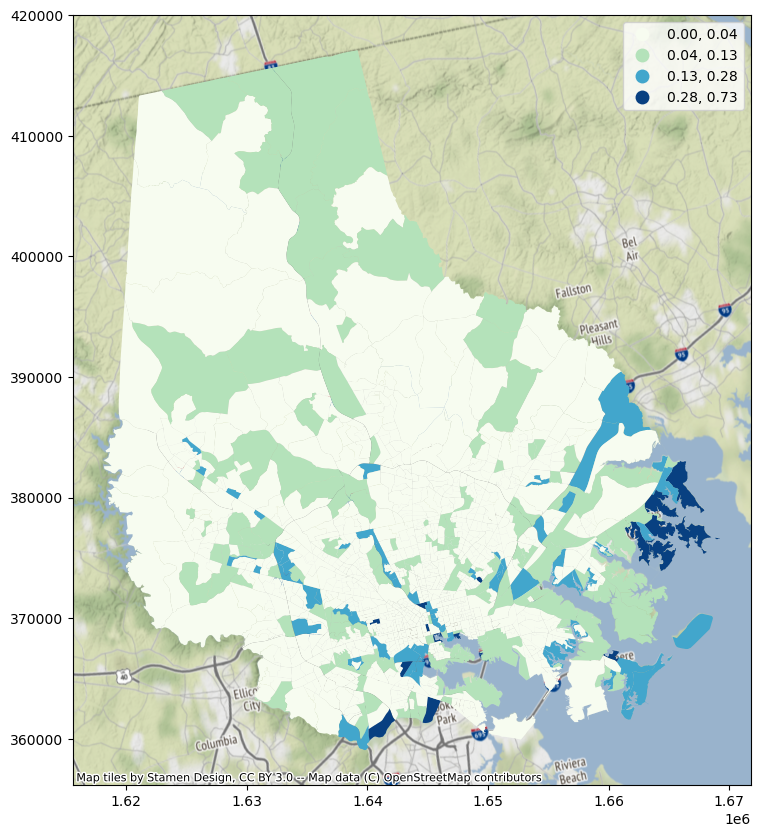

In [314]:
f, ax = plt.subplots(1, figsize=(10, 10))

balt_data.plot(column='perc_fld_area',
               scheme = 'NaturalBreaks',
               k = 4,
               ax = ax,
               cmap = "GnBu", 
               legend=True)

contextily.add_basemap(ax, crs=balt_data_scaled.crs)

In [316]:
#plt.hist(balt_data['perc_fld_area'])

## Linear Regression


In [307]:
X = balt_data_scaled[variables].drop(['perc_fld_area'], axis = 1)
y = balt_data_scaled['perc_fld_area']

In [308]:
X

,pop_density,perc_white,perc_black,perc_bach,perc_pov,perc_rent,perc_vacant
0,-0.393413,0.074560,-0.221077,0.054309,-0.416044,-0.402708,-0.510598
1,-0.183055,0.197905,-0.202924,0.131734,0.476293,0.096815,-0.642196
2,0.573243,0.741588,-0.484918,0.142662,-0.240187,0.782335,-0.253586
3,-0.003521,0.060036,-0.269292,0.467708,0.219642,0.540346,0.398521
4,0.162664,0.570793,-0.432419,0.881021,-0.391800,-0.436528,0.291096
...,...,...,...,...,...,...,...
1175,-0.146790,-0.508519,0.594048,-0.634123,2.547340,0.944860,0.021451
1176,0.357526,-0.599050,0.700558,-0.388940,1.960524,1.172785,-0.163015
1177,1.154026,-0.614483,0.693488,-0.680373,3.277279,1.337171,-0.319618
1178,0.708668,-0.614483,0.713436,-0.312437,2.186788,0.745413,-0.044947


In [309]:
m1 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    X.values,
    # Dependent variable name
    name_y="perc_fld_area",
    # Independent variable name
    name_x=variables[1:7],)

In [310]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :perc_fld_area                Number of Observations:        1167
Mean dependent var  :      1.0556                Number of Variables   :           8
S.D. dependent var  :      2.4559                Degrees of Freedom    :        1159
R-squared           :      0.0625
Adjusted R-squared  :      0.0568
Sum squared residual:    6592.939                F-statistic           :     11.0401
Sigma-square        :       5.688                Prob(F-statistic)     :   1.452e-13
S.E. of regression  :       2.385                Log likelihood        :   -2666.268
Sigma-square ML     :       5.649                Akaike info criterion :    5348.536
S.E of regression ML:      2.3769                Schwarz criterion     :    5389.034

----------------------------------------------------------------------------

## Evaluate OLS Residuals

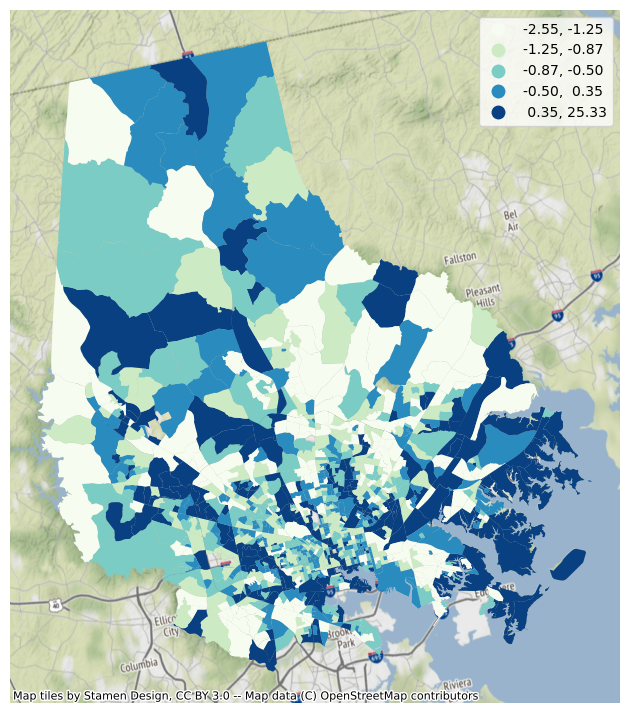

In [291]:
balt_data_scaled['ols residuals'] = m1.u
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot residuals including a legend
balt_data_scaled.plot(
    column="ols residuals",
    legend=True,
    scheme = 'Quantiles',
    cmap = 'GnBu',
    k = 5,
    ax=ax,
)
# Add basemap
contextily.add_basemap(ax, crs=balt_data_scaled.crs)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

## Spatial Lag

In [295]:
wd = weights.Queen.from_dataframe(balt_data_scaled)
# Row standardize weights
wd.transform = "R"

In [296]:
m2 = spreg.GM_Lag(
    # Dependent variable
    y.values,
    # Independent variables
    X.values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="perc_fld_area",
    # Independent variable name
    name_x=variables[1:7],)

In [297]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :perc_fld_area                Number of Observations:        1167
Mean dependent var  :      1.0556                Number of Variables   :           8
S.D. dependent var  :      2.4559                Degrees of Freedom    :        1159
Pseudo R-squared    :      0.2701
Spatial Pseudo R-squared:  0.0579

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.3398731       0.1916300       1.7735904       0.0761309
         pop_density      -0.3443833       0.0829147      -4.1534661       0.0000327
          perc_white       0.6356180       0.4623772      

## Geographically Weighted Regression

In [263]:
##Prepare inputs
#Drop na and ensure arrays are of same length
balt_bg_cent_coords = [(i.x,i.y) for i in balt_data_scaled.loc[X.index].centroid]

X = X.values
y = y.values.reshape((-1,1))

1167

In [264]:
#Calibrate Model
gwr_selector = Sel_BW(balt_bg_cent_coords, y, X, kernel = 'gaussian')
gwr_bw = gwr_selector.search(criterion='AIC')

gwr_results = GWR(balt_bg_cent_coords, y, X, gwr_bw).fit()

In [265]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 612
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.092
Log-likelihood:                                                     869.209
AIC:                                                              -1724.418
AICc:                                                             -1722.179
BIC:                                                              -3880.031
R2:                                                                   0.067
Adj. R2:                                                              0.058

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [184]:
data = ps.io.open(ps.examples.get_path('GData_utm.csv'))
coords = list(zip(data.by_col('X'), data.by_col('Y')))
g_y = np.array(data.by_col('PctBach')).reshape((-1,1))
rural = np.array(data.by_col('PctRural')).reshape((-1,1))
pov = np.array(data.by_col('PctPov')).reshape((-1,1))
african_amer = np.array(data.by_col('PctBlack')).reshape((-1,1))
g_X = np.hstack([rural, pov, african_amer])

In [195]:
g_X

array([[7.560e+01, 1.990e+01, 2.076e+01],
       [1.000e+02, 2.600e+01, 2.686e+01],
       [6.170e+01, 2.410e+01, 1.542e+01],
       [1.000e+02, 2.480e+01, 5.167e+01],
       [4.270e+01, 1.750e+01, 4.239e+01],
       [1.000e+02, 1.510e+01, 3.490e+00],
       [6.460e+01, 1.470e+01, 1.144e+01],
       [7.520e+01, 1.070e+01, 9.210e+00],
       [4.700e+01, 2.200e+01, 3.133e+01],
       [6.620e+01, 1.930e+01, 1.162e+01],
       [1.610e+01, 1.920e+01, 4.168e+01],
       [5.790e+01, 1.830e+01, 2.236e+01],
       [1.000e+02, 1.820e+01, 4.580e+00],
       [6.560e+01, 2.590e+01, 4.147e+01],
       [8.060e+01, 1.320e+01, 1.485e+01],
       [6.320e+01, 2.750e+01, 2.595e+01],
       [7.230e+01, 3.030e+01, 5.219e+01],
       [7.340e+01, 1.560e+01, 3.548e+01],
       [1.000e+02, 3.180e+01, 5.889e+01],
       [4.710e+01, 1.150e+01, 2.019e+01],
       [5.210e+01, 2.410e+01, 3.094e+01],
       [6.850e+01, 1.440e+01, 1.546e+01],
       [4.360e+01, 1.200e+01, 9.100e-01],
       [1.000e+02, 1.830e+01, 2.70